# Transformer

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 实现FFN层

> 这个FFN其实只改变最内侧的维度，比如大小为2，3，4的X输入，即批量2，序列3，维度4。假设FFN是 4，4，8，那么 2,3,4先和4,4做矩阵乘法，表示每个元素的4个维度经过变换还是4，然后激活，然后2,3,4再和4,8做乘法，每个元素的4个维度变换到8个维度，结果是2,3,8
>
> 基于位置：其实就是所有元素顺序不变，只改变里面的值的维度

In [2]:
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [20]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 8])

## Add&Norm 残差链接和层归一化

> Add 就是残差链接，和ResNet原理差不多，可以让模型做很深
>
> 层归一化防止梯度问题，对每个样本做均值0，方差1

In [ ]:
# 比较层归一化和批量归一化区别
ln = nn.LayerNorm(2) # 特征维度2
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
#这里还用了暂退法dropout，避免block结果过拟合
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    # X是进入Block前的输入，Y是Block的输出
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [17]:
# 指定每个批次的形状是3,4 暂退率）0.5
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## Encoder块实现

> 实现了以上的两个模块：Add&Norm，FFN，还有上节实现了的可带掩码多头
>
> 这三个基本部分就是解码器和编码器的组成子块，可以构建编码器和解码器了

In [24]:
# 按照架构图实现所有层
# 多头要指定q,k,v的大小（一般是一样的，输入的序列的每个元素都是q,k,v）和头数
# 层归一要指定序列和维度大小
# FFN要指定输入维度和输出维度大小，但是最后会恢复到原大小num_hiddens
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [22]:
X = torch.ones((2, 100, 24)) # 8个头，每个头维度3，这里提前复制拼接成24
# 多头的掩码，2个批次，第一个批次只有前三个序列有效，第二个批次只有前两个有效
valid_lens = torch.tensor([3, 2]) 
# q,k,v和投影大小都是24
# 归一大小是100,24
# FFN输入维度24，变换到48
# 8个头，暂退率是0.5
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

## Encoder实现

> 一个Encoder包含多个transformer块

In [ ]:
#参数和上面差不多，多个vocab_size用于给元素编码Embedding
# 实现架构的开始部分：使用位置编码和编码
# 然后利用多个transformer块
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        # 初始化序列元素到位置编码和向量的设置
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 实现多个transformer块
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    # Encoder也需要掩码，因为输入的词元可能有些是pad，没用的
    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # 每个transformer块都有一个多头，每个多头都有注意力块
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            # 因为输入的序列是作为q,k,v的，即每个单词融合其他单词的信息
            # 所以注意力图最后两个维度是个方阵，假如是100个词元
            # 就是100*100表示每个词元关注其他词元的注意力多少
            self.attention_weights[  # 这里是多个头的注意力图
                i] = blk.attention.attention.attention_weights
        return X

In [29]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape
# encoder完毕后，输入的2,100,24这2个批次的每批次100单词都拥有互相信息

torch.Size([2, 100, 24])

## 解码器块

> 同样使用上述定义的多头，FFN和Add&Norm实现
>
> 不同于编码器一个块只有一个多头，这里解码器有两个多头，且第一个是掩码自注意力多头，第二个是非自注意力多头
>
> 还有一点，每个编码器多头都用了掩码实际上，但是解码器的多头是为了自回归，编码器和非自注意力多头是为了屏蔽pad无效词元

In [ ]:
# 解码器
# 解码器第一个自注意力多头是要自回归的，只有生成的词元能用做输入，
# 所以设定了参数dec_valid_lens，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    # 初始化完成后设置层和层的数据流向，对比编码器要复杂很多
    # 初始要指定默认输出词元和生成词元数量，初始一般是bos和1
    # X是当前输入，训练时是所有的正确输入，通过掩码自回归
    # 预测时X是上一次Decoder的输出结果
    # state是Encoder的输出结果和有效词元长度
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        # key_values就是当前的所有已生成输出
        # state[2][self.i]保存每个块对应的所有已生成输出
        
        # 预测的初始时 X的内容是'bos'的数字，state[2]都是None，所以会走第一个if，key_values也是'bos'
        # 预测的第二次来的时候，X的内容是预测的第一次的结果，假如是bonjour，走else，key_values保存两个值的数字 '<bos>','bonjour'
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1) # 拼接上一次预测的结果
        state[2][self.i] = key_values  # 保存一下已预测的东西
        # self.training是继承自nn.module的属性，训练方法使用xx.train就行
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            # 已生成的词元个数，每个批次都一致，所以直接repeat就行
            # !!!! 这里是迷惑点，关于dec_valid_length的应用，实际上在多头的时候，传递了dec_valid_length
            # 但是多头会先计算query和key的得分，结果是scores 批次,q个数,k个数 应用dec_valid_length后
            # 结果会变成 第一个批次，第一个q对应1个k的结果，其他列是0
            # 第一个批次，第二个q对应2个k的结果，其他列是0，直到num_steps
            # 最后这个scores掩码矩阵和key_values批量乘，做到输出的X结果内，第一个批次的第一个序列只有第一个序列信息
            # 第一个批次的第二个序列只有前两个序列信息
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        # 这里就是使用了dec_valid_length，举个实际的例子，假设X是64,10,32 key_values也是同样大小
        # 先通过dec_valid_length算出score掩码矩阵，大小是64*10*10，每个格子是词元对其他词元的注意力大小
        # 最后这个掩码得分矩阵再和key_value批乘，64,10,32和64,10,10结果是64，10，32
        # 一个批次的一个序列有10个掩码值，和key_value结果就是对一个批次的十个序乘法即10*32，结果就是对这十个词元加权和
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [33]:
# 已生成词元数量0
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

## 解码器

> 实现架构图功能，使用多个decoker块，实现embedding和位置编码
>
> 增加一个FC将词元输出转为预测概率

In [ ]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers  # decoder块数量
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        # 词元位置编码
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        # 最后的计算X内假设第一个批次，第三个词元，就有前三个词元所有的特征，dense后就是第三个词元输出的结果
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 训练

loss 0.032, 2591.3 tokens/sec on cuda:0


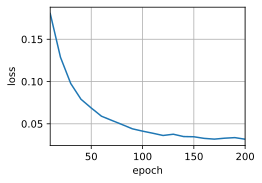

In [47]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [53]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


## 看看注意力图

最后一次预测 `im home . <eos>` 的结果

In [ ]:
# encoder的多头注意力图
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

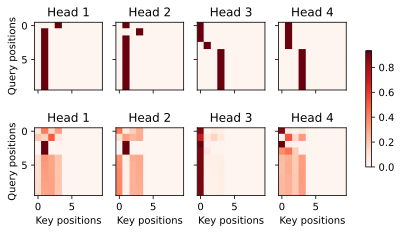

In [ ]:
# 分了2层每层4个头
# 第2层的最后一个头，可以看到有效词大概是4个，每一次query对这四个词的权重都不一样，前几次都比较关注前面的词
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [56]:
# 解码器图
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

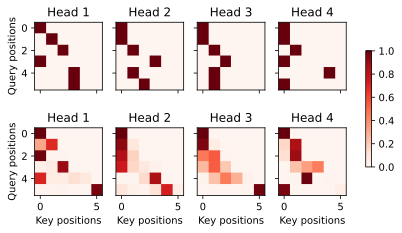

In [ ]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

# 这里只看自注意力，不看交叉注意力的多头模块，并且这里也是2层，每层4个头，看的是预测的时候的情况
# 基本上可以看到第一次query只能看到第一个词，第二次query能看到第二个词，依次越大

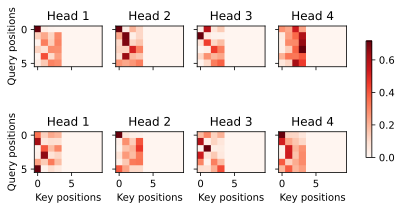

In [ ]:
# 这里是交叉多头注意力，即和encoder的结果进行的
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))
# 可以看到每次query看的encoder的所有词注意力都不一样，encoder的有效词大概是4个